In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F

def visualize_sequence(seq):

    plt.imshow(seq, cmap='cool')
    plt.title('KE')

    plt.show()

## 1. Filling in the Gaps

### a) Constraints of Parameters
The output of the controller is split into each of the different parameters to be used for interacting with the memory. Each parameter is constrained by definition, and can be constrained through functions.

#### K 
K has no constraints, and thus, is taken as the raw output of the controller.
$$ K \in (-\infty, \infty) $$

#### Beta
Beta must be greater than zero. As such, a $ softplus $ output can be used to ensure the output falls in this range. Softplus is defined as:
$$ \beta = softplus(x) = log(1+\exp(x))$$
$$ \beta \in (0,\infty) $$
#### Interpolation: g 
The g parameter is used to interpolate between the last head state, and the new head state.  This can be achieved by keeping g between 0 and 1. This is done using the sigmoid function.
$$ g = \frac{1}{1+exp(-x)} $$
$$ g \in (,1)$$

#### Shift: s
The s parameters is described by a normal distribution over the possible allowable memory shifts one can obtain using the NTM.  The shift parameter is an $ n $ length array, where $ n $ is the maximum allowable shifts one can have in either one direction or 2 direction (depending on how the convolution is performed). This is discussed in question 2.e.  For now, s is a distribution over the number of shifts one would like to obtain. For example, if one wants to allow a shift backwards, forwards, or none at all then $n = 3$ and an appropriate convolution is performed.  Since s is a probability distribution, one can use the softmax function.

$$ s_i = softmax(x_i) = \frac{e^{x_i}}{\sum_k e^{x_k}} $$ 

#### Sharpening: Gamma

Gamma is used to sharpen the location of access following the shifting process. In order to do this, one can use the following formula, with $\gamma > 1$. To ensure $\gamma > 1$ one can use the softplus function, as before, and add 1.
$$\gamma = 1+ softplus(x) = 1 + log(1+ e^x) $$
$$ \gamma \in [1,\infty)$$ 

#### Erase: $e$

Erase is used to erase sections of the previous memory. The erase vector must be between 0 and 1. This can be achieved through the sigmoid non-linearity.

$$ e = sigmoid(x) = \frac{1}{1+e^{-x}$$
$$e \in (0,1)$$

#### Add: $a$

The add vector can have any values and is thus the raw value of the controller's output.

$$a = x$$
$$a \in (-\infty, \infty)$$

### b) Diagram of Dependencies

### 2a) Number of Hyperparameters

For each of the following set ups, we define:
$$m_{inbits} = 9$$
$$m_{memsize} = 100$$
$$n_{cout} = 100$$

#### LSTM

The LSTM has 4 sets of matrices $U$ and $W$. Each of these matrices is size $n_{lstmout} x m_{inbits}$. In this case the LSTM has an input size of $m_{inbits} = 9, and n_{lstmout} = 100$ There is an additional linear transformation transforming the size of the hidden state to the output size, $m_{inbits}-1 = 8$. As such there are:
$$n_{params} = 4*(n_{lstmout}*m_{inbits} + n_{lstmout}^2 + n_{lstmout}) + (n_{lstmout}*(m_{inbits}-1) + m_{inbits}-1) = 44,444$$

#### FC NTM

The fully connected controller has weights size $n_{cout} x m_{in}$ and bias size $n_{cout}$. $m_{in}$ is the sum of bits in, $m_{inbits}$ and $m_{memsize}$.  

The controller thus has:
$$ n_{controller} = n_{cout} x (m_{inbits}+m_{memsize}) + n_{cout} = 11,000$$

Each head has a learnable linear transformation from the size of the controller output to the sum of all head parameters (Beta etc.). The sum of all read head parameters is:
$$ sum_{readparams} = len(K) + len(\beta) + len(g) + len(s) + len(\gamma) = m_{memsize} + 1 + 1 + 3 + 1  = 106$$

Thus the read head has:
$$n_{readhead} = sum_{readparams} + sum_{readparams}*n_{cout} = 10,706$$

For the write head there is are additional erase and add parameters. $a \in \mathbb{R}^{memsize}$ and $e \in \mathbb{R}^{memsize}$.

$$ sum_{writeparams} = len(K) + len(\beta) + len(g) + len(s) + len(\gamma) + len(e) + len(a) = m_{memsize} + 1 + 1 + 3 + 1 + m_{memsize} + m_{memsize} = 306$$

Thus the write head has:

$$n_{writehead} = sum_{writeparams} + sum_{writeparams}*n_{cout} = 30,906$$

Finally there is a transformation from the output of the controller concatenated with the memory read to the final output. This transformation has weights size $(n_{cout} + m_{memsize})*(m_{inbits}-1) = 1600$ and bias size $m_{inbits}-1 = 8$.

Thus the total number of parameters is:
$$n_{params} = n_{controller} + n_{readparams} + n_{writeparams} + (n_{cout} + m_{memsize})*(m_{inbits}-1) + 
m_{inbits}-1 $$
$$n_{params} = 11,000 + 10,706+30,906 + 1600+8 = 54,220$$


#### LSTM NTM
The LSTM NTM differs from the FC NTM only in the controller aspect of the design. The LSTM controller has the same number of parameters as the LSTM model, but without the final transformation. In this case:

$$n_{LSTMcontroller} = 4*(n_{lstmout}*m_{inbits} + n_{lstmout}^2 + n_{lstmout}) = 44,000 $$

Thus the LSTM NTM has:
$$n_{params} = n_{LSTMcontroller} + n_{readhead} + n_{writehead} + (n_{cout} + m_{memsize})*(m_{inbits}-1) + 
m_{inbits}-1 = 87,220 $$


#### Notes:

It's worth noting that the memory itself is not  a learnable parameter.

In [789]:
def dataloader(num_batches, batch_size, sequence_width, min_len, max_len):
    for batch_ind in range(num_batches):
        sequence_len = random.randint(min_len, max_len)
        sequence = np.random.binomial(1, 0.5, (sequence_len, batch_size, sequence_width))
        sequence = Variable(torch.from_numpy(sequence))

        inp = Variable(torch.zeros(sequence_len + 1, batch_size, sequence_width + 1))
        inp[:sequence_len, :, :sequence_width] = sequence
        inp[sequence_len, :, sequence_width] = 1.0
        output = sequence.clone().float()

        yield batch_ind+1, inp.float(), output

In [916]:
REPORTFREQ=10
SAVEFREQ=10
def train_model(model,optimizer,loss_crit,num_epochs):
    mean_losses = []
    mean_accuracies = []
    
    for epoch in range(num_epochs):
        losses = []
        accuracy = []
        dloader = dataloader(num_batches,batch_size,8,1,20)
        for batch_index,x,y in dloader:
            model.hidden = model.init_seq()
            optimizer.zero_grad()
            for i in range(x.shape[0]):
                model.forward(x[i])

            output = Variable(torch.zeros(y.shape))
            for i in range(y.shape[0]):
                output[i] = model.forward()
            acc = evaluate(output,y)

            accuracy.append(acc)
            #print(accuracy[-1])
            loss = loss_crit(output,y)
            loss.backward()
            clip_grads(model)
            optimizer.step()
            losses.append(loss.data[0])
        
        mean_loss =  np.mean(losses)
        mean_accuracy = np.mean(accuracy)
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch+1,mean_loss,mean_accuracy))
        if (epoch%REPORTFREQ==0):
            visualize_sequence(x[:,0,:].data)
            visualize_sequence(torch.round(output[:,0,:]).data)
            
        if (epoch% SAVEFREQ==0):
            model_type = model.ctype
            fname = "./Models/{}-{}-Loss-{}-Accuracy-{}.model".format(model_type,epoch,mean_loss,mean_accuracy)
            torch.save(model.state_dict(),fname)
        mean_losses.append(mean_loss)
        mean_accuracies.append(mean_accuracy)
        
    return mean_losses, mean_accuracies

def evaluate(logits,y):
    preds = torch.round(logits)
    correct =  torch.sum(preds.eq(y).float().data)    
    total = (y.shape[0]*y.shape[1]*y.shape[2])
    accuracy = correct/total
    return accuracy
    
def clip_grads(model):
    parameters = list(filter(lambda x: x.grad is not None, model.parameters()))
    for param in parameters:
        param.grad.data.clamp_(-10, 10)

In [902]:
class LSTM(nn.Module):
    def __init__(self,in_dim, hidden_dim,batch_size = 1,num_bits=8):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim,1)
        self.hidden2label = nn.Linear(hidden_dim, num_bits)
        self.in_size = num_bits+1
        self.batch_size = batch_size
        self.hidden = self.init_hidden()
        self.bits = num_bits
    
    def init_seq(self):
        self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1,self.batch_size,self.hidden_dim))
        c0 = Variable(torch.zeros(1,self.batch_size,self.hidden_dim))
        return (h0, c0)

    def forward(self, x=None):
        if (type(x)==type(None)):
            x = Variable(torch.zeros(self.batch_size,self.bits+1))
        lstm_out,self.hidden = self.lstm(x.unsqueeze(0), self.hidden)
        
        y  = self.hidden2label(lstm_out)
        y = F.sigmoid(y)
        return y
    @property
    def ctype(self):
        return "LSTM"
    
    def num_params(self):
        count = 0
        #Trainable Parameters
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_train_params = sum([np.prod(p.size()) for p in parameters])
        print("Model has {} trainable parameters".format(num_train_params))
            

## 2. b) LSTM Hyperparameter Search

In [903]:
batch_size = 1
num_batches=5000
num_epochs = 52
LS = LSTM(9,100,batch_size)

Model has 45208 trainable parameters
None


Epoch: 1, Loss: 0.6691706191301345, Accuracy: 0.5652435125089478


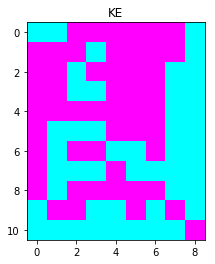

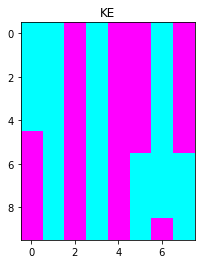

Epoch: 2, Loss: 0.5984784719478339, Accuracy: 0.5995446904851685
Epoch: 3, Loss: 0.5350889828370419, Accuracy: 0.6421557132375708
Epoch: 4, Loss: 0.48503527893227877, Accuracy: 0.6720188751148233
Epoch: 5, Loss: 0.43855844094512575, Accuracy: 0.7049917826899194
Epoch: 6, Loss: 0.41510643841810085, Accuracy: 0.7191097673413618
Epoch: 7, Loss: 0.41769427196471953, Accuracy: 0.7148085707799253
Epoch: 8, Loss: 0.39176946418502484, Accuracy: 0.7327101915250213
Epoch: 9, Loss: 0.3636717928757935, Accuracy: 0.7516863194165225
Epoch: 10, Loss: 0.3516783101580004, Accuracy: 0.7552670504355895
Epoch: 11, Loss: 0.3427735519906055, Accuracy: 0.7607064136635209


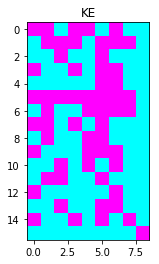

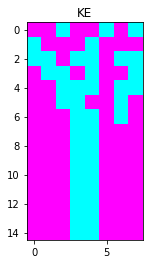

Epoch: 12, Loss: 0.35495794051690244, Accuracy: 0.7519496746779623
Epoch: 13, Loss: 0.323694639163883, Accuracy: 0.7742028377610092
Epoch: 14, Loss: 0.3243413947393874, Accuracy: 0.7735862110384885
Epoch: 15, Loss: 0.308646760769524, Accuracy: 0.7843328224570407
Epoch: 16, Loss: 0.3154000643299032, Accuracy: 0.7784654602655687
Epoch: 17, Loss: 0.3030392330604458, Accuracy: 0.7858878293874597
Epoch: 18, Loss: 0.32327738421548496, Accuracy: 0.7702052891350996
Epoch: 19, Loss: 0.3023170642151209, Accuracy: 0.7841625094816175
Epoch: 20, Loss: 0.30943413580650386, Accuracy: 0.7797452279269578
Epoch: 21, Loss: 0.32452716848533636, Accuracy: 0.7675131480600154


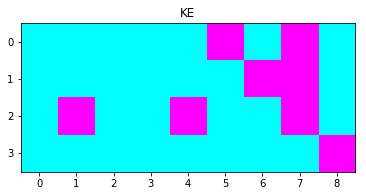

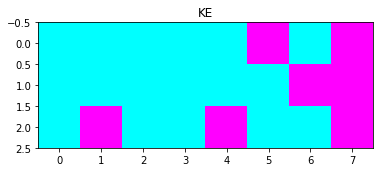

Epoch: 22, Loss: 0.3232448970415486, Accuracy: 0.7710767417496074
Epoch: 23, Loss: 0.2977558730093609, Accuracy: 0.7892255531164742
Epoch: 24, Loss: 0.29207164810496533, Accuracy: 0.7930733014706313
Epoch: 25, Loss: 0.30195446854613334, Accuracy: 0.7857715934233466
Epoch: 26, Loss: 0.30075092037035533, Accuracy: 0.7856537044961832
Epoch: 27, Loss: 0.2989186363208025, Accuracy: 0.7877139509984769
Epoch: 28, Loss: 0.3029609928383255, Accuracy: 0.785290211480556
Epoch: 29, Loss: 0.2878283175683663, Accuracy: 0.7968455791499524
Epoch: 30, Loss: 0.29803146429364724, Accuracy: 0.789962463770105
Epoch: 31, Loss: 0.30034657342109344, Accuracy: 0.789201181378606


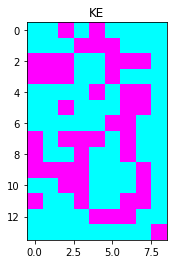

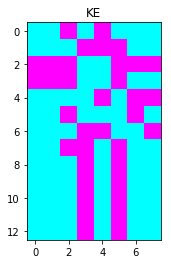

Epoch: 32, Loss: 0.30558416273009936, Accuracy: 0.7877098375744912
Epoch: 33, Loss: 0.28170377920033296, Accuracy: 0.8075996820020794
Epoch: 34, Loss: 0.28001219140456396, Accuracy: 0.8072952198491653
Epoch: 35, Loss: 0.2806904653084841, Accuracy: 0.8085253842113769
Epoch: 36, Loss: 0.27765812074144536, Accuracy: 0.8103220585715885
Epoch: 37, Loss: 0.28363364290177995, Accuracy: 0.8058688895892978
Epoch: 38, Loss: 0.27964094503480763, Accuracy: 0.808356103481357
Epoch: 39, Loss: 0.27547917203088806, Accuracy: 0.8115030495188507
Epoch: 40, Loss: 0.2772183076410175, Accuracy: 0.8094045515814595
Epoch: 41, Loss: 0.28136902035193817, Accuracy: 0.8067159016162286


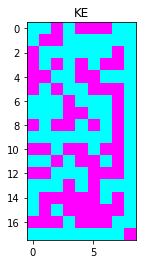

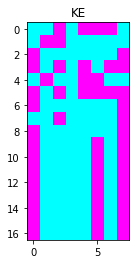

Epoch: 42, Loss: 0.2856751956849566, Accuracy: 0.8034991056894172
Epoch: 43, Loss: 0.2620701729033729, Accuracy: 0.8177345873938153
Epoch: 44, Loss: 0.2815184881952503, Accuracy: 0.805148880015968
Epoch: 45, Loss: 0.27022453194547247, Accuracy: 0.8125453374450626
Epoch: 46, Loss: 0.27890649790495403, Accuracy: 0.8062170198583667
Epoch: 47, Loss: 0.26131047223451753, Accuracy: 0.8156782020052531
Epoch: 48, Loss: 0.2661049056296457, Accuracy: 0.8122083452104312
Epoch: 49, Loss: 0.2688152095439967, Accuracy: 0.8101769875162677
Epoch: 50, Loss: 0.27541588976001613, Accuracy: 0.8103617614435359
Epoch: 51, Loss: 0.2734011117416047, Accuracy: 0.8067273151328376


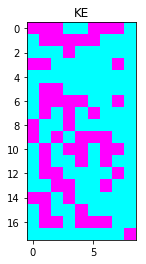

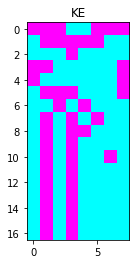

Epoch: 52, Loss: 0.2534296730141354, Accuracy: 0.8211625487152596
Epoch: 1, Loss: 0.6688738191723823, Accuracy: 0.5544281663864171


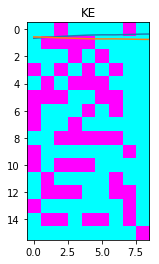

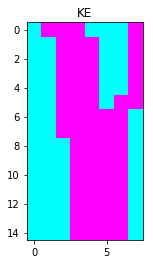

Epoch: 2, Loss: 0.5775753817232325, Accuracy: 0.6047573080535736
Epoch: 3, Loss: 0.519485243037343, Accuracy: 0.6475657686920923
Epoch: 4, Loss: 0.4895783217389835, Accuracy: 0.6673123311655665
Epoch: 5, Loss: 0.44655470063955727, Accuracy: 0.7011484275459662
Epoch: 6, Loss: 0.4277442267405131, Accuracy: 0.7148023145720379
Epoch: 7, Loss: 0.4012260514486261, Accuracy: 0.7385382578045021
Epoch: 8, Loss: 0.3747747876426729, Accuracy: 0.7573716952275021
Epoch: 9, Loss: 0.3708195122952584, Accuracy: 0.7572693944194351
Epoch: 10, Loss: 0.35016436714163685, Accuracy: 0.766042251701472
Epoch: 11, Loss: 0.34337827204937277, Accuracy: 0.7732674868084273


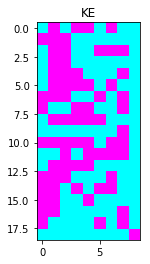

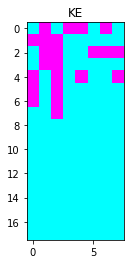

Epoch: 12, Loss: 0.33030668469205055, Accuracy: 0.7816986313258895
Epoch: 13, Loss: 0.33514673050515514, Accuracy: 0.7788148660861413
Epoch: 14, Loss: 0.32844282790043255, Accuracy: 0.7824803403566677
Epoch: 15, Loss: 0.32893274795085425, Accuracy: 0.7802367285829496
Epoch: 16, Loss: 0.32633346186404855, Accuracy: 0.7775463784867094
Epoch: 17, Loss: 0.3283441527898867, Accuracy: 0.7732081065535342
Epoch: 18, Loss: 0.3182835851876023, Accuracy: 0.7765551180540305
Epoch: 19, Loss: 0.3133815226449026, Accuracy: 0.7799092276361839
Epoch: 20, Loss: 0.3153630165750244, Accuracy: 0.7776977334479676
Epoch: 21, Loss: 0.301177138661527, Accuracy: 0.7871349659321156


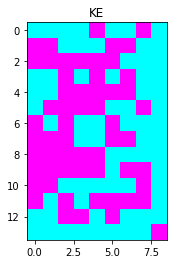

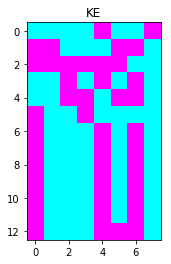

Epoch: 22, Loss: 0.31465579672285376, Accuracy: 0.7787702888627541
Epoch: 23, Loss: 0.3113281353335776, Accuracy: 0.7821249566801018
Epoch: 24, Loss: 0.31024378084920634, Accuracy: 0.7837550207452937
Epoch: 25, Loss: 0.2943289367734852, Accuracy: 0.7927251474613278
Epoch: 26, Loss: 0.3032404508844236, Accuracy: 0.7889608938745724
Epoch: 27, Loss: 0.3254251924117441, Accuracy: 0.7724704594899854
Epoch: 28, Loss: 0.2992637249831066, Accuracy: 0.7880034738898013
Epoch: 29, Loss: 0.29825499120022303, Accuracy: 0.7888284073041252
Epoch: 30, Loss: 0.2926231538162681, Accuracy: 0.7932535545558244
Epoch: 31, Loss: 0.2889186569723069, Accuracy: 0.794802563845683


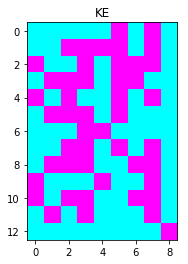

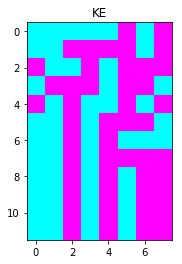

Epoch: 32, Loss: 0.3081197775420562, Accuracy: 0.781850765024664
Epoch: 33, Loss: 0.3047014969011498, Accuracy: 0.7852820883745167
Epoch: 34, Loss: 0.2995523073999339, Accuracy: 0.7884657284053666
Epoch: 35, Loss: 0.28319502768469756, Accuracy: 0.8006758620518198
Epoch: 36, Loss: 0.28501245248363716, Accuracy: 0.7984277459681272
Epoch: 37, Loss: 0.3018196605226266, Accuracy: 0.7881846722547748
Epoch: 38, Loss: 0.2971527853957224, Accuracy: 0.7932786062398214
Epoch: 39, Loss: 0.2899783371081634, Accuracy: 0.7982481449218136
Epoch: 40, Loss: 0.27743818597776954, Accuracy: 0.8066059176848264
Epoch: 41, Loss: 0.26607795272844487, Accuracy: 0.812485348925885


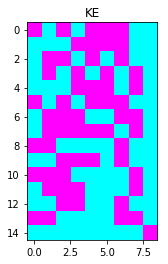

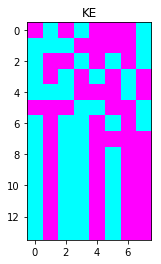

Epoch: 42, Loss: 0.28620912716307756, Accuracy: 0.799121267846146
Epoch: 43, Loss: 0.2677765436270706, Accuracy: 0.8102173718116249
Epoch: 44, Loss: 0.27502663274518735, Accuracy: 0.805360375601136
Epoch: 45, Loss: 0.26210042420471324, Accuracy: 0.8146142377022272
Epoch: 46, Loss: 0.28975736615981595, Accuracy: 0.7981682314649574
Epoch: 47, Loss: 0.2784988103015432, Accuracy: 0.8026042251674623
Epoch: 48, Loss: 0.27858984719453744, Accuracy: 0.8013152484321234
Epoch: 49, Loss: 0.284068577953526, Accuracy: 0.7975720155504541
Epoch: 50, Loss: 0.29351738977358993, Accuracy: 0.7976392953840534
Epoch: 51, Loss: 0.28760558833549854, Accuracy: 0.8019628825588326


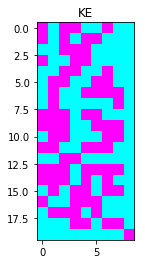

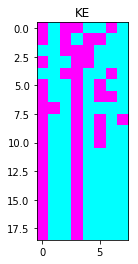

Epoch: 52, Loss: 0.2761912746400215, Accuracy: 0.805479501820419
Epoch: 1, Loss: 0.6856752181053162, Accuracy: 0.5511810355524249


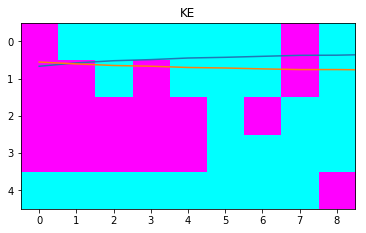

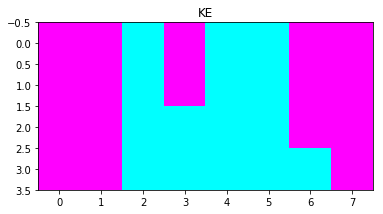

Epoch: 2, Loss: 0.6601574232578278, Accuracy: 0.6052871521158152
Epoch: 3, Loss: 0.6340200006961823, Accuracy: 0.6322899637746154
Epoch: 4, Loss: 0.6190434941053391, Accuracy: 0.6355017445059241
Epoch: 5, Loss: 0.6081587437391281, Accuracy: 0.636644549645401
Epoch: 6, Loss: 0.5967399309575557, Accuracy: 0.6418122662981584
Epoch: 7, Loss: 0.5844109846949578, Accuracy: 0.6478047085557631
Epoch: 8, Loss: 0.5744126330465078, Accuracy: 0.653607688032212
Epoch: 9, Loss: 0.555131036542356, Accuracy: 0.6672533434431925
Epoch: 10, Loss: 0.5279297441728413, Accuracy: 0.6873069930192356
Epoch: 11, Loss: 0.5443878202959895, Accuracy: 0.6807051410476778


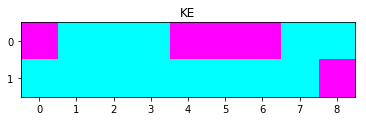

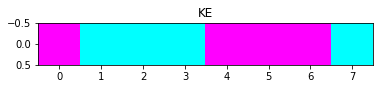

Epoch: 12, Loss: 0.5148866667449474, Accuracy: 0.705863204812903
Epoch: 13, Loss: 0.5171600442044437, Accuracy: 0.7082553661448631
Epoch: 14, Loss: 0.49755956398230045, Accuracy: 0.7213498396815173
Epoch: 15, Loss: 0.5006123308846727, Accuracy: 0.7200828688975284
Epoch: 16, Loss: 0.49005272788368165, Accuracy: 0.7301165729018574
Epoch: 17, Loss: 0.4779460236518644, Accuracy: 0.7369986218034632
Epoch: 18, Loss: 0.4765979712014087, Accuracy: 0.7370675770900925
Epoch: 19, Loss: 0.4656109888097271, Accuracy: 0.7433144002868906
Epoch: 20, Loss: 0.46861061932053416, Accuracy: 0.742834477582531
Epoch: 21, Loss: 0.4518954674177803, Accuracy: 0.7528737307435857


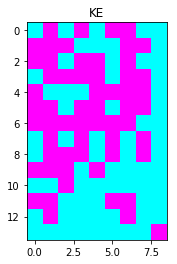

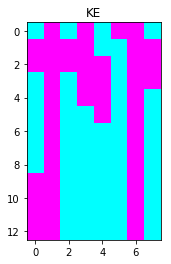

Epoch: 22, Loss: 0.42507187530444934, Accuracy: 0.7705473477492151
Epoch: 23, Loss: 0.4319418217537459, Accuracy: 0.7660480026552395
Epoch: 24, Loss: 0.4297755277189426, Accuracy: 0.7673105928765507
Epoch: 25, Loss: 0.4056622693114914, Accuracy: 0.7814274838637455
Epoch: 26, Loss: 0.4053402290681843, Accuracy: 0.7815383899204081
Epoch: 27, Loss: 0.4041660412296187, Accuracy: 0.7816668466601768
Epoch: 28, Loss: 0.3940790878138505, Accuracy: 0.7854517631175584
Epoch: 29, Loss: 0.39328018108510876, Accuracy: 0.7854150557240747
Epoch: 30, Loss: 0.37689202642685266, Accuracy: 0.7949235912700561
Epoch: 31, Loss: 0.37630097609694346, Accuracy: 0.7946428601816141


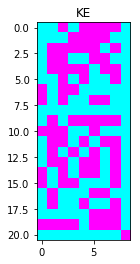

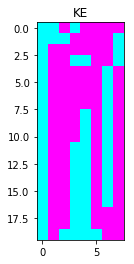

Epoch: 32, Loss: 0.3616422741079587, Accuracy: 0.8033298607504896
Epoch: 33, Loss: 0.36917817970027683, Accuracy: 0.7975574421098338
Epoch: 34, Loss: 0.3609291661832249, Accuracy: 0.804516539520421
Epoch: 35, Loss: 0.3492318966117455, Accuracy: 0.8096495113542289
Epoch: 36, Loss: 0.34305584168969655, Accuracy: 0.8141385833157639
Epoch: 37, Loss: 0.32842946834507164, Accuracy: 0.8221524255429383
Epoch: 38, Loss: 0.33009865851840003, Accuracy: 0.8212694817415986
Epoch: 39, Loss: 0.33062982822710185, Accuracy: 0.8195603406698222
Epoch: 40, Loss: 0.3427913102736929, Accuracy: 0.8122333863408264
Epoch: 41, Loss: 0.319854730631283, Accuracy: 0.8250811355622792


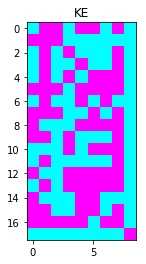

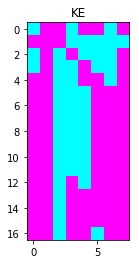

Epoch: 42, Loss: 0.30698332610150103, Accuracy: 0.8311672815529414
Epoch: 43, Loss: 0.31323550221446206, Accuracy: 0.8269112870112774
Epoch: 44, Loss: 0.3084668979286798, Accuracy: 0.83004429550648
Epoch: 45, Loss: 0.29956934427295345, Accuracy: 0.8328890448444743
Epoch: 46, Loss: 0.2903318923866609, Accuracy: 0.8378813054755702
Epoch: 47, Loss: 0.29149320379062554, Accuracy: 0.8360944512374021
Epoch: 48, Loss: 0.29301893870451023, Accuracy: 0.8339829064792706
Epoch: 49, Loss: 0.284783871518448, Accuracy: 0.8388481917965935
Epoch: 50, Loss: 0.2815383242589305, Accuracy: 0.839133003360159
Epoch: 51, Loss: 0.2838244184462237, Accuracy: 0.8369458527300014


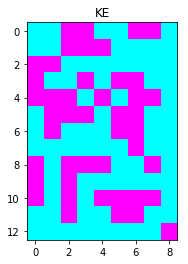

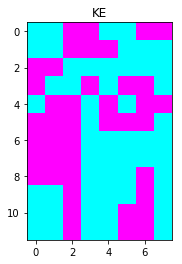

Epoch: 52, Loss: 0.29088752987986666, Accuracy: 0.8303281865973293
Epoch: 1, Loss: 0.6756085500717163, Accuracy: 0.5729726968565919


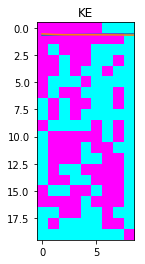

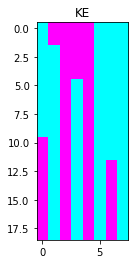

Epoch: 2, Loss: 0.6337965819239616, Accuracy: 0.61976623845732
Epoch: 3, Loss: 0.6090293038785458, Accuracy: 0.6247850961931515
Epoch: 4, Loss: 0.5869487107247114, Accuracy: 0.6246747697430709
Epoch: 5, Loss: 0.5741484761461616, Accuracy: 0.6248696732880983
Epoch: 6, Loss: 0.5645746896266938, Accuracy: 0.6366214057324255
Epoch: 7, Loss: 0.5419780279621482, Accuracy: 0.6622932581762923
Epoch: 8, Loss: 0.5146993740536272, Accuracy: 0.6862509638241875
Epoch: 9, Loss: 0.5061877202896867, Accuracy: 0.692772896000843
Epoch: 10, Loss: 0.4797737153735943, Accuracy: 0.7104332897163895
Epoch: 11, Loss: 0.4715133905081311, Accuracy: 0.7163849681190413


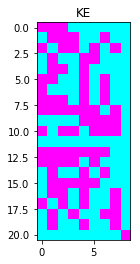

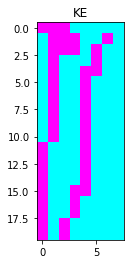

Epoch: 12, Loss: 0.46102480961068065, Accuracy: 0.7251336429003572
Epoch: 13, Loss: 0.4468771474334644, Accuracy: 0.7343510754501776
Epoch: 14, Loss: 0.4257048224182217, Accuracy: 0.7482869129891866
Epoch: 15, Loss: 0.44093124820804225, Accuracy: 0.7342388502566405
Epoch: 16, Loss: 0.4095753707193653, Accuracy: 0.7552977394376351
Epoch: 17, Loss: 0.4038452056943206, Accuracy: 0.7541927821434672
Epoch: 18, Loss: 0.399278596665361, Accuracy: 0.7555907208565857
Epoch: 19, Loss: 0.3854651544379885, Accuracy: 0.7650070555830907
Epoch: 20, Loss: 0.3410738643441291, Accuracy: 0.7939239675874951
Epoch: 21, Loss: 0.37707686464159634, Accuracy: 0.7689163403948562


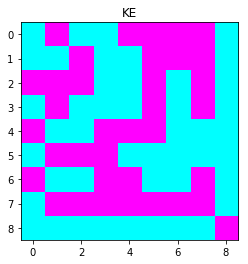

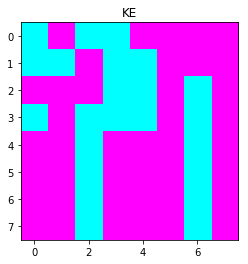

Epoch: 22, Loss: 0.3523415438149241, Accuracy: 0.786892159345857
Epoch: 23, Loss: 0.34958737694498265, Accuracy: 0.7874666154816116
Epoch: 24, Loss: 0.3499750542778638, Accuracy: 0.7857297297145149
Epoch: 25, Loss: 0.34160911363929336, Accuracy: 0.7916698345956589
Epoch: 26, Loss: 0.34586525911503124, Accuracy: 0.786594804079864
Epoch: 27, Loss: 0.33909604193721316, Accuracy: 0.7912856174129878
Epoch: 28, Loss: 0.31894040274037977, Accuracy: 0.8046401340940621
Epoch: 29, Loss: 0.3097553107200947, Accuracy: 0.8114605873503862
Epoch: 30, Loss: 0.31942437455845357, Accuracy: 0.8061339976833882
Epoch: 31, Loss: 0.3084061086630536, Accuracy: 0.8139873345758989


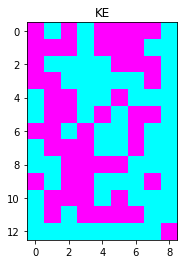

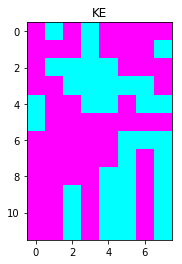

Epoch: 32, Loss: 0.3137351739124133, Accuracy: 0.8092642700211296
Epoch: 33, Loss: 0.30167701497445526, Accuracy: 0.818142701076873
Epoch: 34, Loss: 0.3150458309003152, Accuracy: 0.8081675634953711
Epoch: 35, Loss: 0.2854207817065617, Accuracy: 0.8272190124033604
Epoch: 36, Loss: 0.28779727741659006, Accuracy: 0.8261617017388786
Epoch: 37, Loss: 0.28808821493494907, Accuracy: 0.8265557239973649
Epoch: 38, Loss: 0.297003101180846, Accuracy: 0.819849930423034
Epoch: 39, Loss: 0.2704075552686554, Accuracy: 0.837631069745528
Epoch: 40, Loss: 0.26973504373770996, Accuracy: 0.8358636182908937
Epoch: 41, Loss: 0.291357495339922, Accuracy: 0.8231249062478629


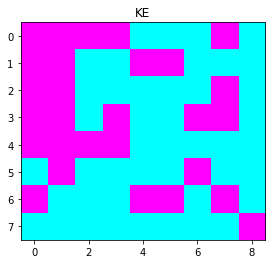

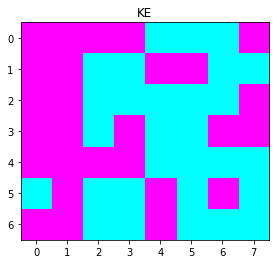

Epoch: 42, Loss: 0.27531634902358926, Accuracy: 0.8322265486321814
Epoch: 43, Loss: 0.26086081972868125, Accuracy: 0.8406250165653919
Epoch: 44, Loss: 0.2581066506157513, Accuracy: 0.8425538328819443
Epoch: 45, Loss: 0.25491297727957135, Accuracy: 0.8428755317431535
Epoch: 46, Loss: 0.2491654736828641, Accuracy: 0.8467598268789175
Epoch: 47, Loss: 0.25780040067948723, Accuracy: 0.8405497821758134
Epoch: 48, Loss: 0.2497550781410173, Accuracy: 0.8450663666882224
Epoch: 49, Loss: 0.26284186191597836, Accuracy: 0.8367319146475299
Epoch: 50, Loss: 0.25529612131105023, Accuracy: 0.8421948909947982
Epoch: 51, Loss: 0.24437712965979153, Accuracy: 0.8496645013109525


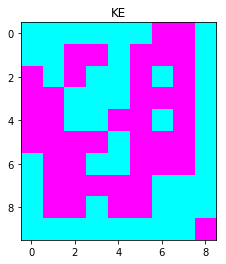

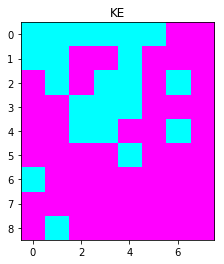

Epoch: 52, Loss: 0.23636444357522668, Accuracy: 0.8552252085955839


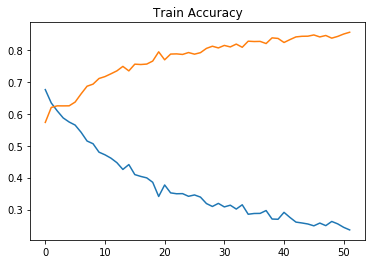

In [881]:
lrs = [1e-3,1e-4]
momentums = [0.8,0.9]
alphas = [0.95]

for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            LS = LSTM(9,100,batch_size)
            optimizer = torch.optim.RMSprop(LS.parameters(), lr=lr,momentum=momentum,alpha=alpha)
            loss_crit = torch.nn.BCELoss()
            REPORTFREQ=10
            SAVEFREQ=10
            train_loss, train_accuracy = train_model(LS,optimizer,loss_crit,num_epochs)
            plt.title('Train Loss')
            plt.plot(train_loss)
            plt.show()
            plt.title('Train Accuracy')
            plt.plot(train_accuracy)
            plt.show()
            

In [910]:
class Memory(nn.Module):
    def __init__(self,N,M,batch_size):
        super(Memory,self).__init__()
        self.N = N
        self.M = M
        self.batch_size = batch_size

        self.register_buffer('mem_bias', Variable(torch.Tensor(N, M)))

        stdev = 1/(np.sqrt(N + M))
        nn.init.uniform(self.mem_bias, -stdev, stdev)

        
    def read(self,w):
        w_read = w.view(self.batch_size,1,-1)
        return torch.matmul(w_read,self.memory).squeeze(1)
    
    def write(self,w,e,a):
        self.old_memory = self.memory
        self.memory = Variable(torch.zeros(self.old_memory.shape))
        self.memory = self.old_memory*(1-torch.matmul(w.unsqueeze(-1),e.unsqueeze(1)))
        self.memory = self.memory + torch.matmul(w.unsqueeze(-1),a.unsqueeze(1))
        
    def reset_mem(self):
        self.memory = self.mem_bias.clone().repeat(self.batch_size, 1, 1)
        #print(self.memory.shape)
class ReadHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(ReadHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_read = nn.Linear(self.in_size, memory.M+1+1+3+1)
        nn.init.xavier_normal(self.linear_read.weight)
        
        
        
        self.param_sizes = [memory.M,1,1,3,1]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
        
    def update_w(self,x):
        k = x[:,:self.param_locations[0]]
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        prev_w = self.w

        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-12,k+1e-12,dim=-1),dim=1)
        wg = g*wc + (1-g)*self.w
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))
        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-12)
        
        self.w = wt
        
    def read_memory(self,x):
        inputs = self.linear_read(x)
        
        self.update_w(inputs)
        read = self.memory.read(self.w)
        
        return read
    
class WriteHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(WriteHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_write = nn.Linear(self.in_size, memory.M+1+1+3+1+memory.M + memory.M)
        nn.init.xavier_normal(self.linear_write.weight)
        self.param_sizes = [memory.M,1,1,3,1,memory.M,memory.M,memory.M]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6, 2*memory.M+6, 3*memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def create_write_params(self,x):
        k = x[:,:self.param_locations[0]].clone()
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        e = F.sigmoid(x[:,self.param_locations[4]:self.param_locations[5]])
        a = x[:,self.param_locations[5]:self.param_locations[6]]
        
        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-12,k+1e-12,dim=-1),dim=1)
        wg = g*wc + (1-g)*self.w
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))

        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-12)
        self.w = wt
        return wt,e,a
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
    
    def write_memory(self,x):
        inputs = self.linear_write(x)
        w, e, a = self.create_write_params(inputs)
        
        self.memory.write(w,e,a)
        
class FFController(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(FFController,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear_control = nn.Linear(in_dim,out_dim)
    
    def forward(self,x):
        
        a1 = self.linear_control(x)
        #print(np.isnan(np.sum(a1.data[0].numpy())))
        return a1
    @property
    def ctype(self):
        return 'FC'
    



In [893]:
class FCNTM(nn.Module):
    def __init__(self,N,M,input_size,output_size,batch_size):
        super(FCNTM,self).__init__()
        self.memory = Memory(N,M,batch_size)
        self.controller = FFController(input_size+M,100)
        self.readHead = ReadHead(self.memory,self.controller,batch_size)        
        self.writeHead = WriteHead(self.memory,self.controller,batch_size)
        self.prev_read = Variable(torch.zeros(batch_size,M))
        self.batch_size = batch_size
        self.in_size = input_size
        self.LinearOut = nn.Linear(100+M,output_size)
    
    def forward(self, x=None):
        if x is None:
            batch_size = self.batch_size
            x = Variable(torch.zeros(batch_size,self.in_size))
        inputs = torch.cat((x,self.prev_read),dim=1)
        c_output = self.controller.forward(inputs)
        
        
        
        self.prev_read = self.readHead.read_memory(c_output)
        self.writeHead.write_memory(c_output)
        inp2output = torch.cat((c_output,self.prev_read),dim=1)
        output = F.sigmoid(self.LinearOut(inp2output))

        return output
    
    def init_seq(self):
        self.readHead.reset_w()
        self.writeHead.reset_w()
        self.memory.reset_mem()
        self.prev_read = Variable(torch.zeros(self.batch_size,M))
    @property
    def ctype(self):
        return "FC_NTM"

### 2b) Fully Connected NTM HyperParameter Search

Epoch: 1, Loss: 0.6930753195285797, Accuracy: 0.5270621397565284


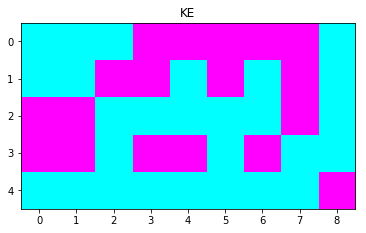

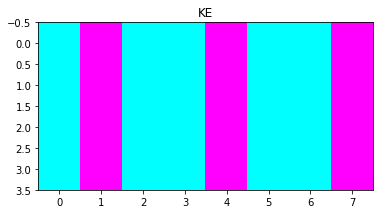

Epoch: 2, Loss: 0.6763067419528961, Accuracy: 0.5954712949256196
Epoch: 3, Loss: 0.37858641570061446, Accuracy: 0.821517033552318
Epoch: 4, Loss: 0.06374294735223521, Accuracy: 0.9859730590681249
Epoch: 5, Loss: 0.054191954206617085, Accuracy: 0.9893974070262382
Epoch: 6, Loss: 0.08345392618823098, Accuracy: 0.9828110702614379
Epoch: 7, Loss: 0.050820697680755984, Accuracy: 0.9919535427807487
Epoch: 8, Loss: 0.02437364560458809, Accuracy: 0.9962543997668998
Epoch: 9, Loss: 0.00907982915911782, Accuracy: 0.99915
Epoch: 10, Loss: 0.014065436901205678, Accuracy: 0.9986833333333334
Epoch: 11, Loss: 0.1357705385865266, Accuracy: 0.9913172384203345


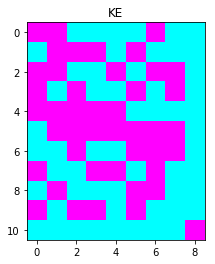

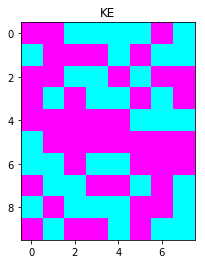

Epoch: 12, Loss: 0.13409733729361323, Accuracy: 0.9877359789107951
Epoch: 13, Loss: 0.019649697158928305, Accuracy: 0.9989
Epoch: 14, Loss: 6.132494171726233e-06, Accuracy: 1.0


RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -nan at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THNN/generic/BCECriterion.c:34

In [926]:
batch_size = 1
num_batches=500
num_epochs = 32
Ms = [100]
N = 128
SAVEFREQ=5
lrs = [1e-4]
momentums = [0.9]
alphas = [0.95]

for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            for M in Ms:
                fc_ntm = FCNTM(N,M,8+1,8,batch_size)
                optimizer = torch.optim.RMSprop(fc_ntm.parameters(), lr=lr,momentum=momentum,alpha=alpha)
                loss_crit = torch.nn.BCELoss()
                train_loss, train_accuracy = train_model(fc_ntm,optimizer,loss_crit,num_epochs)
                plt.plot(train_loss)
                plt.show()
                plt.plot(train_accuracy)
                plt.show()

In [ ]:
class LSTMController(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(LSTMController,self).__init__()
        self.lstm = nn.LSTM(in_dim, 100,1)
        self.batch_size = batch_size
        self.init_hidden()
        self.out_dim = out_dim
    
    def init_seq(self):
        self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1,self.batch_size,100))
        c0 = Variable(torch.zeros(1,self.batch_size,100))
        self.hidden = (h0, c0)

    def forward(self, x=None):
        lstm_out,self.hidden = self.lstm(x.unsqueeze(0), self.hidden)
        return lstm_out.squeeze(0)
    
    @property
    def ctype(self):
        return 'LSTM'

In [904]:
class LSTMNTM(nn.Module):
    def __init__(self,N,M,input_size,output_size,batch_size):
        super(LSTMNTM,self).__init__()
        self.memory = Memory(N,M,batch_size)
        self.controller = LSTMController(input_size+M,100)
        self.readHead = ReadHead(self.memory,self.controller,batch_size)        
        self.writeHead = WriteHead(self.memory,self.controller,batch_size)
        self.prev_read = Variable(torch.zeros(batch_size,M))
        self.batch_size = batch_size
        self.in_size = input_size
        self.LinearOut = nn.Linear(100+M,output_size)
    
    def forward(self, x=None):
        if x is None:
            batch_size = self.batch_size
            x = Variable(torch.zeros(batch_size,self.in_size))
        inputs = torch.cat((x,self.prev_read),dim=1)
        c_output = self.controller.forward(inputs)
        
        
        
        self.prev_read = self.readHead.read_memory(c_output)
        self.writeHead.write_memory(c_output)
        inp2output = torch.cat((c_output,self.prev_read),dim=1)
        output = F.sigmoid(self.LinearOut(inp2output))

        return output
    
    def init_seq(self):
        self.readHead.reset_w()
        self.writeHead.reset_w()
        self.memory.reset_mem()
        self.prev_read = Variable(torch.zeros(self.batch_size,M))
        if self.controller.ctype == 'LSTM':
            self.controller.init_hidden()
            
    @property
    def ctype(self):
        return "LSTM_NTM"

### 2b) LSTM-NTM Hyperparameter Search

Epoch: 1, Loss: 0.6900652314424515, Accuracy: 0.5312001203882976


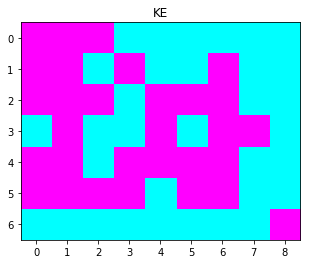

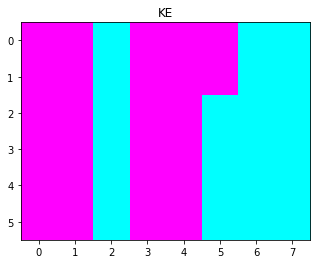

Epoch: 2, Loss: 0.6748144835233688, Accuracy: 0.5894517644764935
Epoch: 3, Loss: 0.6593203526735306, Accuracy: 0.6001034063395325
Epoch: 4, Loss: 0.6356422092914581, Accuracy: 0.6132917483917871
Epoch: 5, Loss: 0.6270550830364228, Accuracy: 0.6122591117763815
Epoch: 6, Loss: 0.6194119750857353, Accuracy: 0.6103544393869376
Epoch: 7, Loss: 0.5969882826507091, Accuracy: 0.6291897668196528
Epoch: 8, Loss: 0.6133900510519743, Accuracy: 0.6086606533097536
Epoch: 9, Loss: 0.5823709633648395, Accuracy: 0.6231551206995188
Epoch: 10, Loss: 0.5732586443983019, Accuracy: 0.6270076326741284
Epoch: 11, Loss: 0.5681746904924512, Accuracy: 0.6278962269971171


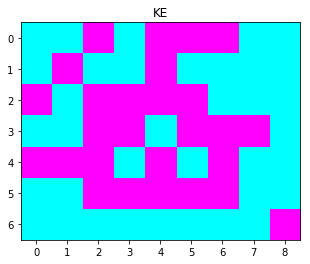

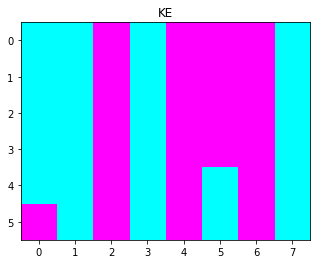

Epoch: 12, Loss: 0.5762685868293047, Accuracy: 0.6190375683441086
Epoch: 13, Loss: 0.562033916849643, Accuracy: 0.632518111198442
Epoch: 14, Loss: 0.5622957293726504, Accuracy: 0.6350934788798663
Epoch: 15, Loss: 0.5359871257944032, Accuracy: 0.6680109745066595
Epoch: 16, Loss: 0.4960877932999283, Accuracy: 0.7278104761402169
Epoch: 17, Loss: 0.37484865055046973, Accuracy: 0.8418287234383692
Epoch: 18, Loss: 0.2410246277526021, Accuracy: 0.92250502320929
Epoch: 19, Loss: 0.21739296261203708, Accuracy: 0.9349834152281328
Epoch: 20, Loss: 0.03943689390644431, Accuracy: 0.9907595048602498
Epoch: 21, Loss: 0.03219315196331809, Accuracy: 0.9969479166666666


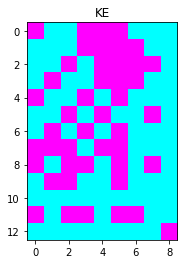

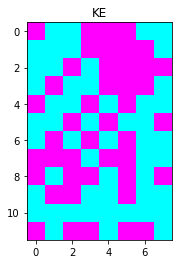

Epoch: 22, Loss: 1.0453271878887448e-05, Accuracy: 1.0
Epoch: 23, Loss: 1.4431214983934293e-07, Accuracy: 1.0
Epoch: 24, Loss: 4.709024982792742e-07, Accuracy: 1.0
Epoch: 25, Loss: 7.636212016590149e-09, Accuracy: 1.0
Epoch: 26, Loss: 2.649725482764542e-09, Accuracy: 1.0
Epoch: 27, Loss: 1.488319069903321e-09, Accuracy: 1.0
Epoch: 28, Loss: 8.625686876775895e-10, Accuracy: 1.0
Epoch: 29, Loss: 7.872541071540784e-10, Accuracy: 1.0
Epoch: 30, Loss: 5.366324123436128e-10, Accuracy: 1.0
Epoch: 31, Loss: 5.785676234701387e-10, Accuracy: 1.0


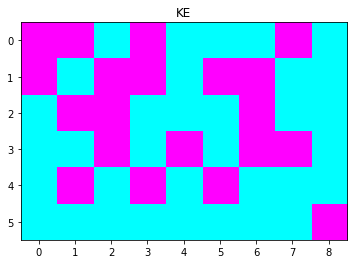

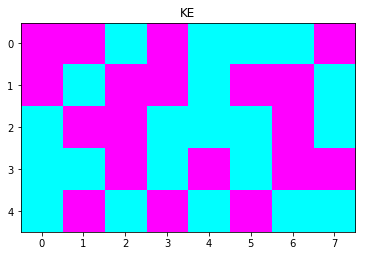

Epoch: 32, Loss: 4.249406158618463e-10, Accuracy: 1.0
Epoch: 33, Loss: 4.227344331982075e-10, Accuracy: 1.0
Epoch: 34, Loss: 2.4435856438775533e-10, Accuracy: 1.0
Epoch: 35, Loss: 1.247706146423218e-06, Accuracy: 1.0
Epoch: 36, Loss: 8.26232980579919e-10, Accuracy: 1.0
Epoch: 37, Loss: 4.0448184850626345e-10, Accuracy: 1.0
Epoch: 38, Loss: 4.1756048987928727e-10, Accuracy: 1.0
Epoch: 39, Loss: 2.1330018750223557e-10, Accuracy: 1.0
Epoch: 40, Loss: 1.5363248926508755e-10, Accuracy: 1.0
Epoch: 41, Loss: 2.572451794748479e-10, Accuracy: 1.0


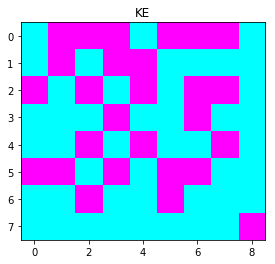

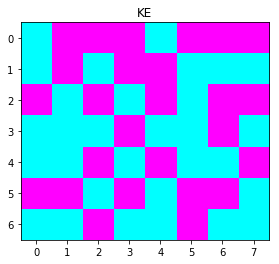

Epoch: 42, Loss: 1.578832400407626e-10, Accuracy: 1.0
Epoch: 43, Loss: 1.8086505644554495e-10, Accuracy: 1.0
Epoch: 44, Loss: 1.3767829138886488e-10, Accuracy: 1.0
Epoch: 45, Loss: 1.5786846421003004e-10, Accuracy: 1.0
Epoch: 46, Loss: 1.7894495956891076e-10, Accuracy: 1.0
Epoch: 47, Loss: 1.5851220943512503e-10, Accuracy: 1.0
Epoch: 48, Loss: 1.5305099467996518e-10, Accuracy: 1.0
Epoch: 49, Loss: 1.7240881371432398e-10, Accuracy: 1.0
Epoch: 50, Loss: 1.1761919996734067e-10, Accuracy: 1.0
Epoch: 51, Loss: 1.2610359265662064e-10, Accuracy: 1.0


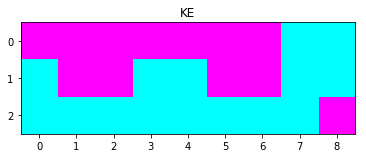

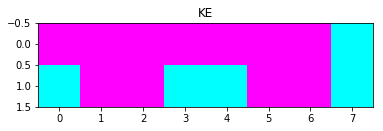

Epoch: 52, Loss: 8.998263345506505e-11, Accuracy: 1.0
Epoch: 53, Loss: 1.2431188705676332e-10, Accuracy: 1.0
Epoch: 54, Loss: 9.308806370005029e-11, Accuracy: 1.0
Epoch: 55, Loss: 1.0131628166705313e-10, Accuracy: 1.0
Epoch: 56, Loss: 9.975955034182554e-11, Accuracy: 1.0
Epoch: 57, Loss: 6.087386434706389e-11, Accuracy: 1.0
Epoch: 58, Loss: 1.0461224862073644e-10, Accuracy: 1.0
Epoch: 59, Loss: 9.655521192265467e-11, Accuracy: 1.0
Epoch: 60, Loss: 8.667708742242375e-11, Accuracy: 1.0
Epoch: 61, Loss: 9.401146719304268e-11, Accuracy: 1.0


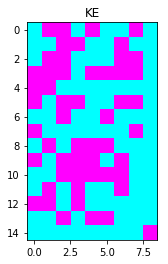

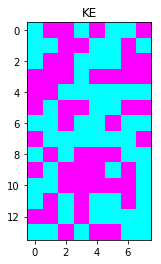

Epoch: 62, Loss: 8.684332980339604e-11, Accuracy: 1.0
Epoch: 63, Loss: 6.922110602769482e-11, Accuracy: 1.0
Epoch: 64, Loss: 6.703069039941129e-11, Accuracy: 1.0
Epoch: 65, Loss: 9.391586804812294e-11, Accuracy: 1.0
Epoch: 66, Loss: 7.977826126733152e-11, Accuracy: 1.0
Epoch: 67, Loss: 7.254773611524824e-11, Accuracy: 1.0
Epoch: 68, Loss: 6.270397829438723e-11, Accuracy: 1.0
Epoch: 69, Loss: 6.961456171011762e-11, Accuracy: 1.0
Epoch: 70, Loss: 4.827430829298235e-11, Accuracy: 1.0
Epoch: 71, Loss: 1.3179143637146545e-10, Accuracy: 1.0


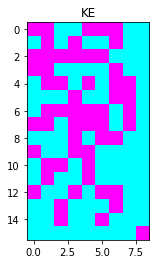

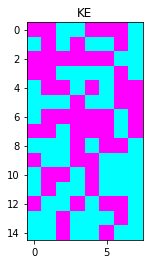

Epoch: 72, Loss: 5.4226645112166045e-11, Accuracy: 1.0
Epoch: 73, Loss: 6.425011366277718e-11, Accuracy: 1.0
Epoch: 74, Loss: 7.064378861504654e-11, Accuracy: 1.0
Epoch: 75, Loss: 3.637864627722628e-11, Accuracy: 1.0
Epoch: 76, Loss: 5.836781576682229e-11, Accuracy: 1.0
Epoch: 77, Loss: 4.2119962872545766e-11, Accuracy: 1.0
Epoch: 78, Loss: 4.176543646604997e-11, Accuracy: 1.0
Epoch: 79, Loss: 6.016971851492691e-11, Accuracy: 1.0
Epoch: 80, Loss: 1.1926768281379806e-10, Accuracy: 1.0
Epoch: 81, Loss: 5.2664045536635456e-11, Accuracy: 1.0


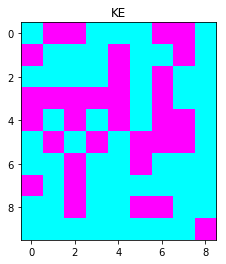

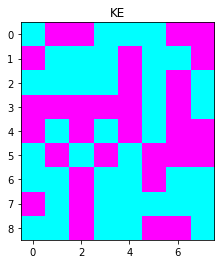

Epoch: 82, Loss: 4.8896323133875225e-11, Accuracy: 1.0
Epoch: 83, Loss: 5.402385970867951e-11, Accuracy: 1.0
Epoch: 84, Loss: 7.919743982365626e-11, Accuracy: 1.0
Epoch: 85, Loss: 1.0930203649117676e-10, Accuracy: 1.0
Epoch: 86, Loss: 4.060511772513973e-11, Accuracy: 1.0
Epoch: 87, Loss: 5.257305496996455e-11, Accuracy: 1.0
Epoch: 88, Loss: 1.0209574528494397e-10, Accuracy: 1.0
Epoch: 89, Loss: 4.5140879821592686e-11, Accuracy: 1.0
Epoch: 90, Loss: 6.172865309796725e-11, Accuracy: 1.0
Epoch: 91, Loss: 2.932841124364364e-11, Accuracy: 1.0


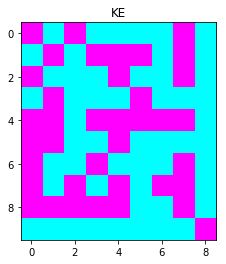

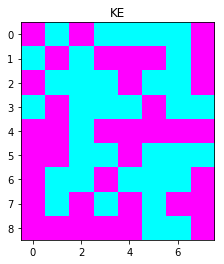

Epoch: 92, Loss: 4.0373346371064115e-11, Accuracy: 1.0
Epoch: 93, Loss: 4.976611919251233e-11, Accuracy: 1.0
Epoch: 94, Loss: 3.149091302686365e-11, Accuracy: 1.0
Epoch: 95, Loss: 1.794156984872425e-10, Accuracy: 1.0
Epoch: 96, Loss: 5.638895653604752e-11, Accuracy: 1.0
Epoch: 97, Loss: 3.881822003702802e-11, Accuracy: 1.0
Epoch: 98, Loss: 5.185754292451848e-11, Accuracy: 1.0
Epoch: 99, Loss: 4.138255567327819e-11, Accuracy: 1.0
Epoch: 100, Loss: 6.05202304891899e-11, Accuracy: 1.0


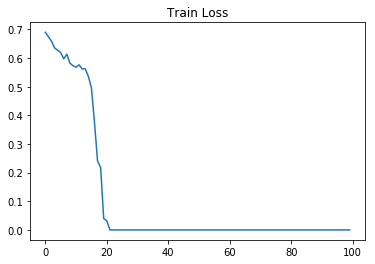

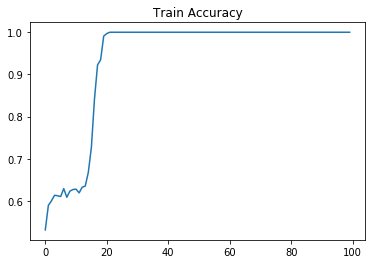

In [919]:
batch_size = 1
num_batches=500
num_epochs = 100
Ms = [100]
N = 128

lrs = [1e-4]
momentums = [0.9]
alphas = [0.95]

for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            for M in Ms:
                lstm_ntm = LSTMNTM(N,M,8+1,8,batch_size)
                optimizer = torch.optim.RMSprop(lstm_ntm.parameters(), lr=lr,momentum=momentum,alpha=alpha)
                loss_crit = torch.nn.BCELoss()
                train_loss, train_accuracy = train_model(lstm_ntm,optimizer,loss_crit,num_epochs)
                plt.title('Train Loss')
                plt.plot(train_loss)
                plt.show()
                plt.title('Train Accuracy')
                plt.plot(train_accuracy)
                plt.show()


### 2c) Generalization to Longer Sequences
Below I will test longer sequences for each of the best models created so far. 

In [496]:
F.conv1d(Variable(torch.Tensor([4,1,2,3,4]).view(1,1,-1)),Variable(torch.Tensor([1,0]).view(1,1,-1))).view(1,-1)

Variable containing:
 4  1  2  3
[torch.FloatTensor of size 1x4]

### 2d) Visualizing the Read and Write Heads

### 2.e) Understanding the Shift Operator

The shift operator is used to shift the focus of the memory by some number of locations.  It can be noted that the shift operator operates with modulo N where N is the number of locations available in the memory.

In [ ]:
class LSTMNTM(nn.Module):
    def __init__(self,N,M,input_size,output_size,batch_size):
        super(LSTMNTM,self).__init__()
        self.memory = Memory(N,M,batch_size)
        self.controller = LSTMController(input_size+M,100)
        self.readHead = ReadHead(self.memory,self.controller,batch_size)        
        self.writeHead = WriteHead(self.memory,self.controller,batch_size)
        self.prev_read = Variable(torch.zeros(batch_size,M))
        self.batch_size = batch_size
        self.in_size = input_size
        self.LinearOut = nn.Linear(100+M,output_size)
    
    def forward(self, x=None):
        if x is None:
            batch_size = self.batch_size
            x = Variable(torch.zeros(batch_size,self.in_size))
        inputs = torch.cat((x,self.prev_read),dim=1)
        c_output = self.controller.forward(inputs)
        
        
        
        self.prev_read = self.readHead.read_memory(c_output)
        self.writeHead.write_memory(c_output)
        inp2output = torch.cat((c_output,self.prev_read),dim=1)
        output = F.sigmoid(self.LinearOut(inp2output))

        return output
    
    def init_seq(self):
        self.readHead.reset_w()
        self.writeHead.reset_w()
        self.memory.reset_mem()
        self.prev_read = Variable(torch.zeros(self.batch_size,M))
        if self.controller.ctype == 'LSTM':
            self.controller.init_hidden()
            
    @property
    def ctype(self):
        return "LSTM_NTM"

In [ ]:
class LSTMController(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(LSTMController,self).__init__()
        self.lstm = nn.LSTM(in_dim, 100,1)
        self.batch_size = batch_size
        self.init_hidden()
        self.out_dim = out_dim
    
    def init_seq(self):
        self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1,self.batch_size,100))
        c0 = Variable(torch.zeros(1,self.batch_size,100))
        self.hidden = (h0, c0)

    def forward(self, x=None):
        lstm_out,self.hidden = self.lstm(x.unsqueeze(0), self.hidden)
        return lstm_out.squeeze(0)
    
    @property
    def ctype(self):
        return 'LSTM'

In [ ]:
class Memory(nn.Module):
    def __init__(self,N,M,batch_size):
        super(Memory,self).__init__()
        self.N = N
        self.M = M
        self.batch_size = batch_size

        self.register_buffer('memory_bias', Variable(torch.Tensor(N, M)))

        stand_dev = 1/(np.sqrt(self.N + self.M))
        nn.init.uniform(self.memory_bias, -stand_dev, stand_dev)

    def read(self,w):
        w_read = w.view(self.batch_size,1,-1)
        return torch.matmul(w_read.unsqueeze(1),self.memory).squeeze(1)
    
    def write(self,w,e,a):
        self.old_memory = self.memory
        self.memory = Variable(torch.zeros(self.old_memory.shape))
        self.memory = self.old_memory*(1-torch.matmul(w.unsqueeze(-1),e.unsqueeze(1)))
        self.memory = self.memory + torch.matmul(w.unsqueeze(-1),a.unsqueeze(1))
        
    def reset_mem(self):
        self.memory = self.memory_bias.clone().repeat(self.batch_size, 1, 1)

class ReadHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(ReadHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_read = nn.Linear(self.in_size, memory.M+1+1+3+1)
        self.param_sizes = [memory.M,1,1,3,1]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
        
    def update_w(self,x):
        k = x[:,:self.param_locations[0]].clone()
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        prev_w = self.w

        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-16,k+1e-16,dim=-1),dim=1)
        wg = g*wc + (1-g)*wc
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))
        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1))
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-16)
        
        self.w = wt
        
    def read_memory(self,x):
        inputs = self.linear_read(x)
        
        self.update_w(inputs)
        read = self.memory.read(self.w)
        
        return read
    
class WriteHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(WriteHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_write = nn.Linear(self.in_size, memory.M+1+1+3+1+memory.M + memory.M)
        self.param_sizes = [memory.M,1,1,3,1,memory.M,memory.M,memory.M]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6, 2*memory.M+6, 3*memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def create_write_params(self,x):
        k = x[:,:self.param_locations[0]].clone()
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        e = F.sigmoid(x[:,self.param_locations[4]:self.param_locations[5]])
        a = x[:,self.param_locations[5]:self.param_locations[6]]
        
        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-16,k+1e-16,dim=-1),dim=1)
        wg = g*wc + (1-g)*wc
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))

        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1))
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-16)
        self.w = wt
        return wt,e,a
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
    
    def write_memory(self,x):
        inputs = self.linear_write(x)
        w, e, a = self.create_write_params(inputs)
        
        self.memory.write(w,e,a)